# Main Approaches for Dimensionality Reduction

## Projection
一般的に訓練データは特徴量次元に対して均一に分布しておらず、いくつかの特徴量はほぼ一定であることが多い。よって訓練データはより小さい次元の部分空間(subspace)に投影することができる。

In [2]:
import numpy as np
from scipy.spatial.transform import Rotation

m=60
X=np.zeros((m,3))
np.random.seed(42)
angles=(np.random.rand(m)**3 + 0.5)* 2 *np.pi
X[:,0], X[:,1]=np.cos(angles), np.sin(angles) * 0.5
X+=0.28*np.random.randn(m, 3)
X=Rotation.from_rotvec([np.pi /29, -np.pi/20,np.pi /4]).apply(X)
X+=[0.2, 0, 0.2]

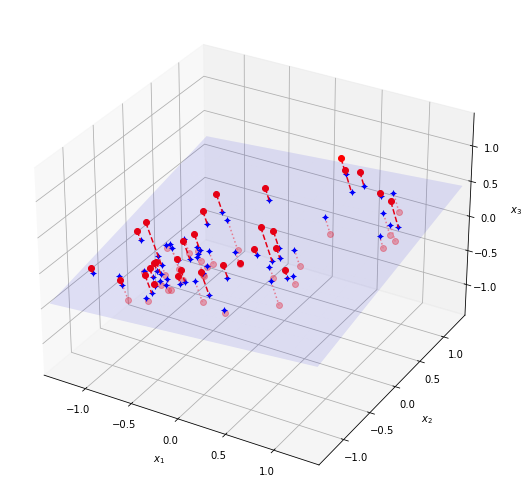

In [3]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca=PCA(n_components =2)
X2D=pca.fit_transform(X)
X3D_inv=pca.inverse_transform(X2D)
X_centered = X-X.mean(axis=0)
U,s, Vt =np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                    np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2,:2], Vt[:2, 2])
z = w1*(x1 -pca.mean_[0]) + w2*(x2 - pca.mean_[1]) - pca.mean_[2]
X3D_above=X[X[:,2] >= X3D_inv[:,2]]
X3D_below=X[X[:,2] < X3D_inv[:,2]]

fig=plt.figure(figsize=(9,9))
ax=fig.add_subplot(111, projection="3d")

ax.plot(X3D_below[:,0], X3D_below[:,1],X3D_below[:,2], 'ro', alpha=0.3)
for i in range(m):
    if X[i, 2]<X3D_inv[i,2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ':', color= '#F88')

ax.plot_surface(x1, x2, z, alpha=0.1, color = 'b')
ax.plot(X3D_inv[:,0], X3D_inv[:,1], X3D_inv[:,2], 'b+')
ax.plot(X3D_inv[:,0], X3D_inv[:,1], X3D_inv[:,2], 'b.')

for i in range(m):
    if X[i,2] >=X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], 'r--')

ax.plot(X3D_above[:,0], X3D_above[:,1], X3D_above[:,2], 'ro')

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel('$x_1$', labelpad=8, rotation=0)
    ax.set_ylabel('$x_2$', labelpad=8, rotation=0)
    ax.set_zlabel('$x_3$', labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[0:2])
    ax.set_zlim(axes[0:2])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

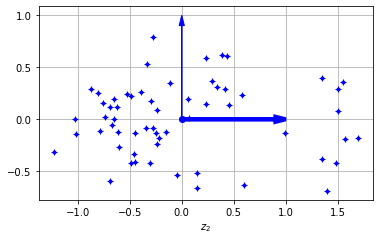

In [4]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1, aspect ='equal')
ax.plot(X2D[:,0], X2D[:,1], 'b+')
ax.plot(X2D[:,0], X2D[:,1], 'b.')
ax.plot([0],[0],'bo')
ax.arrow(0,0,1,0, head_width=0.05, length_includes_head= True,
        head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0,0,0,1, head_width=0.05, length_includes_head= True,
        head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel('$z_1$')
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_xlabel('$z_2$', rotation=0)
ax.set_axisbelow(True)
ax.grid(True)

スイスロールデータセットのように、部分空間はねじれたり曲がったりすることがある。このような場合投影は有効でない。

In [5]:
from sklearn.datasets import make_swiss_roll
X_swiss, t= make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

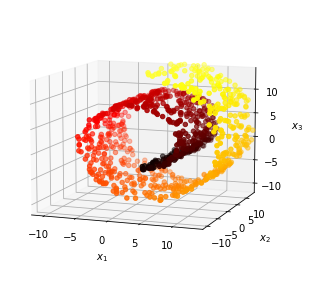

In [6]:
from matplotlib.colors import ListedColormap

darker_hot=ListedColormap(plt.cm.hot(np.linspace(0,0.8, 256)))

axes= [-11.5, 14,-2, 23,-12,15]

fig=plt.figure(figsize=(6,5))
ax=fig.add_subplot(111, projection='3d')
ax.scatter(X_swiss[:,0], X_swiss[:,1], X_swiss[:,2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)

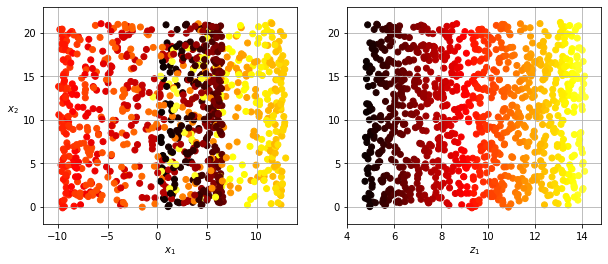

In [7]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.scatter(X_swiss[:,0], X_swiss[:,1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel('$x_1$')
plt.ylabel('$x_2$', labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:,1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel('$z_1$')
plt.grid(True)

## Manifold Learning

多様体学習。訓練データが沿う多様体をモデリングする。スイスロールは2D多様体。2次元形状を3次元空間で曲げたものである。

次元削減は訓練スピードを向上させるが、いつも解が良くなったり簡単になったりするわけではない。これはデータ次第。  
以下の例で3D空間では複雑な決定境界となるが、2D多様体では直線で表せる。これを暗黙的に想定してしまう。

(-12.0, 15.0)

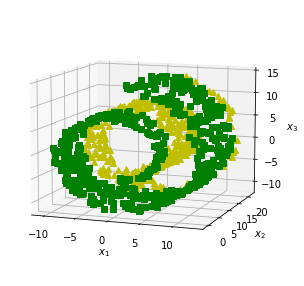

In [8]:
positive_class= 2*(t[:] -4) > X_swiss[:,1]
X_pos=X_swiss[positive_class]
X_neg=X_swiss[~positive_class]

fig=plt.figure(figsize=(6,5))
ax =plt.subplot(1,1,1, projection='3d')
ax.view_init(10,-70)
ax.plot(X_neg[:,0], X_neg[:,1],X_neg[:,2], 'y^')
ax.plot(X_pos[:,0], X_pos[:,1],X_pos[:,2], 'gs')
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel('$x_1$', rotation=0)
ax.set_ylabel('$x_2$', rotation=0)
ax.set_zlabel('$x_3$', rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])


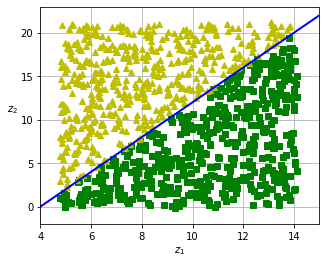

In [9]:
fig=plt.figure(figsize=(5,4))
ax =plt.subplot(1,1,1)
ax.plot(t[positive_class], X_swiss[positive_class,1], 'gs')
ax.plot(t[~positive_class], X_swiss[~positive_class,1], 'y^')
ax.plot([4,15],[0,22], 'b-', linewidth=2)
ax.axis([4,15,axes[2], axes[3]])
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$', rotation=0, labelpad=8)
ax.grid(True)


次の例では3D空間では簡単な決定境界だが、2D多様体では複雑になる。

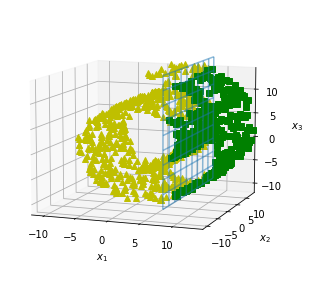

In [10]:
axes = [-11.5, 14, -2,23, -12,15]
x2s=np.linspace(axes[2], axes[3], 10)
x3s=np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class=X_swiss[:,0] > 5
X_pos=X_swiss[positive_class]
X_neg=X_swiss[~positive_class]

fig=plt.figure(figsize=(6,5))
ax =plt.subplot(1,1,1, projection='3d')
ax.view_init(10,-70)
ax.plot(X_neg[:,0], X_neg[:,1],X_neg[:,2], 'y^')
ax.plot_wireframe(5,x2,x3,alpha=0.5)
ax.plot(X_pos[:,0], X_pos[:,1],X_pos[:,2], 'gs')
set_xyz_axes(ax, axes)

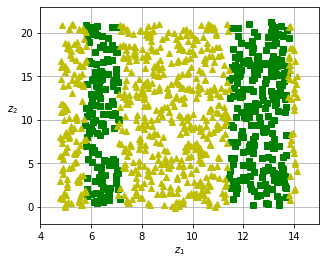

In [11]:
fig=plt.figure(figsize=(5,4))
ax =plt.subplot(1,1,1)
ax.plot(t[positive_class], X_swiss[positive_class,1], 'gs')
ax.plot(t[~positive_class], X_swiss[~positive_class,1], 'y^')
ax.axis([4,15,axes[2], axes[3]])
ax.set_xlabel('$z_1$')
ax.set_ylabel('$z_2$', rotation=0, labelpad=8)
ax.grid(True)


# PCA

PCAは次元削減の最も一般的な手法。

In [45]:
np.random.seed(4)
m =60
w1, w2 = 0.1,0.3
noise=0.1

angles=np.random.rand(m) *3*np.pi/2 -0.5
X=np.empty((m,3))
X[:,0] =np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m)/2
X[:,1] =np.sin(angles)*0.7 + noise * np.random.randn(m)/2
X[:,2] =X[:,0] *w1 + X[:,1] * w2  + noise * np.random.randn(m)


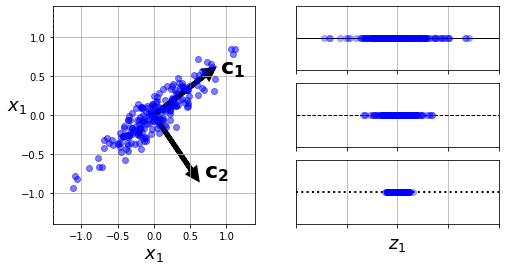

In [66]:
angle = np.pi/5
stretch = 5
m=200

np.random.seed(3)
X_test = np.random.randn(m,2) /10
X_test = X_test.dot(np.array([[stretch,0],[0,1]]))
X_test = X_test.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]])

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle-2*np.pi/6), np.sin(angle-2*np.pi/6)])
u3 = np.array([np.cos(angle-np.pi/2), np.sin(angle-np.pi/2)])

X_proj1 = X_test.dot(u1.reshape(-1,1))
X_proj2 = X_test.dot(u2.reshape(-1,1))
X_proj3 = X_test.dot(u3.reshape(-1,1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0,0), rowspan=3)
plt.plot([-1.4,-1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], 'k-', linewidth =1)
plt.plot([-1.4,-1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], 'k--', linewidth =1)
plt.plot([-1.4,-1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], 'k:', linewidth =2)
plt.plot(X_test[:,0], X_test[:,1], 'bo', alpha=0.5)
plt.axis([-1.4,1.4,-1.4,1.4])
plt.arrow(0,0,u1[0], u1[1], head_width = 0.1, linewidth =5, length_includes_head=True, head_length=0.1,fc='k', ec='k')
plt.arrow(0,0,u3[0], u3[1], head_width = 0.1, linewidth =5, length_includes_head=True, head_length=0.1,fc='k', ec='k')
plt.text(u1[0]+0.1, u1[1] -0.05, r'$\mathbf{c_1}$', fontsize= 22)
plt.text(u3[0]+0.1, u3[1], r'$\mathbf{c_2}$', fontsize= 22)
plt.xlabel('$x_1$', fontsize= 18)
plt.ylabel('$x_1$', fontsize= 18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2),(0,1))
plt.plot([-2,2],[0,0], 'k-', linewidth =1)
plt.plot(X_proj1[:,0], np.zeros(m), 'bo', alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2,2,-1,1])
plt.grid(True)

plt.subplot2grid((3,2),(1,1))
plt.plot([-2,2],[0,0], 'k--', linewidth =1)
plt.plot(X_proj2[:,0], np.zeros(m), 'bo', alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2,2,-1,1])
plt.grid(True)

plt.subplot2grid((3,2),(2,1))
plt.plot([-2,2],[0,0], 'k:', linewidth =2)
plt.plot(X_proj3[:,0], np.zeros(m), 'bo', alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2,2,-1,1])
plt.xlabel('$z_1$', fontsize= 18)
plt.grid(True)


PCAはトレーニングセットの分散が最大となる軸(c1)を識別する。またそれに直交する2つ目の軸も見つかる。これは次に分散が大きい方向。

## Principal Components

[np.linalg.svd](https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html):SVDを求める。$X =U\Sigma V^T$  
Vが主成分の単位ベクトル。

In [46]:
import numpy as np

X_centered=X-X.mean(axis=0)
U, s, Vt=np.linalg.svd(X_centered)
c1= Vt.T[:,0]
c2=Vt.T[:,1]

In [47]:
m,n = X.shape
S=np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [48]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

## Projecting Down to d Dimensions

以下の計算で次元削減できる。

In [51]:
W2 = Vt.T[:,:2]
X2D =X_centered @ W2
X2D_using_svd=X2D

In [50]:
print(X.shape)
print(X2D.shape)

(60, 3)
(60, 2)


## Using Scikit-Learn

[PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA)

In [52]:
from sklearn.decomposition import PCA

pca= PCA(n_components=2)
X2D=pca.fit_transform(X)

In [53]:
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [54]:
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

In [56]:
np.allclose(X2D, -X2D_using_svd)

True

3次元の点の復元。情報の欠損があるため元のデータとは一致しない。

In [57]:
X3D_inv =pca.inverse_transform(X2D)
np.allclose(X3D_inv, X)

False

エラーの計算。

In [58]:
np.mean(np.sum(np.square(X3D_inv- X), axis=1))

0.010170337792848549

`inverse_transform`は以下のような処理を行っている。sklearnのPCAでは自動で平均によるセンタリングを行っている。

In [59]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2,:])

In [60]:
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

`components_`で計算した主成分を表示。

In [62]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [61]:
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

## Explained Variance Ratio
`explained_variance_ratio_`:PCAで選択した各成分によって説明される分散の比率

In [63]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

第一成分で84.2%、第二成分で14.6%説明できる。

2D化したとき、約1.1%の情報が失われている。

In [64]:
1- pca.explained_variance_ratio_.sum()

0.011195535570688975

`explained_variance_ratio_`の計算方法。sは行列Sの対角成分。

In [65]:
np.square(s)/np.square(s).sum()

array([0.84248607, 0.14631839, 0.01119554])

## Choosing the Right Number of Dimensions
はじめに次元削減をしないでPCAを実行し、varianceが0.95になる最小の次元を求める。

In [19]:
from sklearn.datasets import fetch_openml

mnist=fetch_openml('mnist_784', as_frame=False)
X_train, y_train=mnist.data[:60000], mnist.target[:60000]
X_test, y_test=mnist.data[60000:], mnist.target[60000:]

pca=PCA()
pca.fit(X_train)
cumsum=np.cumsum(pca.explained_variance_ratio_)
d= np.argmax(cumsum>=0.95) +1
print(d)

154


これでn_components=dとしてもう一度PCAを実行できるがより良い方法としてcumsumの比率(0~1)をn_componentsとして直接指定できる。

In [20]:
pca=PCA(n_components= 0.95)
X_reduced=pca.fit_transform(X_train)

In [21]:
pca.n_components_

154

In [22]:
pca.explained_variance_ratio_.sum()

0.9501960192613033

## PCA for Compression
次元削減によってMNISTのデータは150/784=20%の容量(圧縮)にできた。

`inverse_transform`で逆に復元することも可能。

In [23]:
pca=PCA(n_components =154)
X_reduced = pca.fit_transform(X_train)
X_recovered= pca.inverse_transform(X_reduced)

In [24]:
def plot_digits(instances, images_per_row=5, **options):
    size =28
    images_per_row = min(len(instances), images_per_row)
    n_rows=(len(instances)-1)//images_per_row +1
    
    n_empty = n_rows* images_per_row-len(instances)
    padded_instances=np.concatenate([instances, np.zeros((n_empty, size*size))], axis=0)
    
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    
    big_image=image_grid.transpose(0,2,1,3).reshape(n_rows * size, images_per_row * size)
    
    plt.imshow(big_image, cmap ='binary', **options)
    plt.axis('off')

Text(0.5, 1.0, 'Compressed')

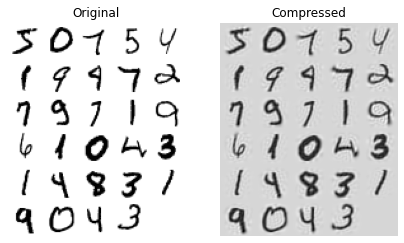

In [25]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title('Original')
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title('Compressed')

# Randomized PCA

svd_solverを`randomized`に設定。主成分(近似的な)を見つけるのが高速になる。
デフォルトでsvd_solverは`auto`。m(データ数)かn(特徴数)が500超かつd(主成分数)がmかnの80%未満なら`randomized`、そうでなければ`full`で動く。

In [26]:
rnd_pca=PCA(n_components=154, svd_solver='randomized')
X_reduced=rnd_pca.fit_transform(X_train)

# Incremental PCA

[IncrementalPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.IncrementalPCA.html#sklearn.decomposition.IncrementalPCA): 訓練データをミニバッチに分割して処理。訓練のためにデータすべてをメモリに置かなくてもいい。

In [27]:
from sklearn.decomposition import IncrementalPCA

n_batches=100
inc_pca=IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [28]:
X_recovered_inc_pca=inc_pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'Compressed')

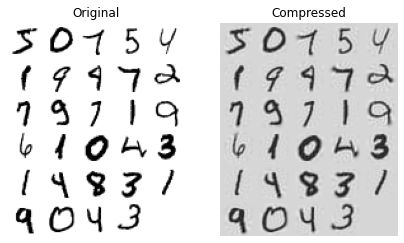

In [29]:
plt.figure(figsize=(7,4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title('Original')
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.title('Compressed')

代替として[np.memmap](https://numpy.org/doc/stable/reference/generated/numpy.memmap.html)が使える。ディスク上の大きな配列からなるバイナリファイルをメモリ上にあるかのように扱える。この場合`partial_fit`ではなくいつもの`fit`が使える。

In [30]:
filename='my_mnist.mmap'
X_mmap = np.memmap(filename, dtype='float32', mode = 'write', shape = X_train.shape)
X_mmap[:]=X_train
X_mmap.flush()

In [31]:
X_mm=np.memmap(filename, dtype='float32', mode='readonly').reshape(-1, 784)

batch_size=X_mm.shape[0]//n_batches
inc_pca=IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=600, n_components=154)

# Kernel PCA

[KernelPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA): カーネルトリックを利用した非線形のPCA。

スイスロールでテスト。

In [32]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components =2, kernel ='rbf', gamma=0.04)
X_reduced=rbf_pca.fit_transform(X_swiss)

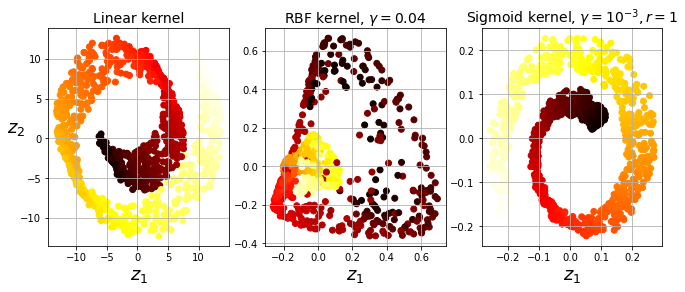

In [33]:
lin_pca=KernelPCA(n_components=2, kernel = 'linear', fit_inverse_transform = True)
rbf_pca=KernelPCA(n_components=2, kernel = 'rbf', gamma = 0.0433, fit_inverse_transform = True)
sig_pca=KernelPCA(n_components=2, kernel = 'sigmoid', gamma=0.001, coef0=1, fit_inverse_transform = True)

y=t>6.9
plt.figure(figsize=(11,4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"),
                           (132, rbf_pca, 'RBF kernel, $\gamma=0.04$'),
                           (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced=pca.fit_transform(X_swiss)
    if subplot==132:
        X_reduced_rbf=X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:,0], X_reduced[:,1],c=t, cmap=plt.cm.hot)
    plt.xlabel('$z_1$',fontsize=18)
    if subplot == 131:
        plt.ylabel('$z_2$', fontsize=18,rotation=0)
    plt.grid(True)
    


# Selecting a Kernel and Tuning Hyperparameters

kPCAは教師なし学習なのでそれだけだと良いカーネルの選択やハイパラ探索が行えない(性能指標がない)が、
次元削減は教師あり学習の前処理として使われる事が多いため、組み合わせればグリッドサーチで最適なカーネルとパラメータを決める事ができる。

パイプラインではじめにkPCAで次元削減、次にロジスティック回帰で分類を解く。

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf= Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression(solver='lbfgs'))
])

param_grid=[{
    'kpca__gamma':np.linspace(0.03, 0.05, 10),
    'kpca__kernel':['rbf', 'sigmoid']
}]

grid_search=GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_swiss,y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [35]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


再構築エラーが最小になるようパラメータを選択するということもできる。  
kPCAはカーネルによって特徴空間に配置してから線形のPCAをかけている。再構築(逆変換)によって特徴空間上に戻すことはできるが、無限次元なのでそこから元の空間に戻すことはできない。が、元の空間上で再構築点がどのあたりに位置するかを見つけることはできる(it is possible to find a point in the original space that would map close to the reconstructed point)。これをreconstruction pre-imageと呼び、元のデータとの2乗誤差を求めることでパラメータ選択をする。

`fit_inverse_transform=True`とすると逆変換メソッド`inverse_transform`が行えるようになる。

In [36]:
rbf_pca=KernelPCA(n_components=2, kernel='rbf', gamma=0.0433,
                 fit_inverse_transform=True)
X_reduced= rbf_pca.fit_transform(X_swiss)
X_preimage=rbf_pca.inverse_transform(X_reduced)

In [37]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X_swiss, X_preimage)

32.78630879576617

# LLE
[LLE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding)(Locally Linear Embedding)はManifold learningの一種。はじめに訓練データ間の距離(関係性)を求め、近傍での距離を維持しながらデータを低次元で表現する。

In [38]:
from sklearn.manifold import LocallyLinearEmbedding

lle =LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced= lle.fit_transform(X_swiss)

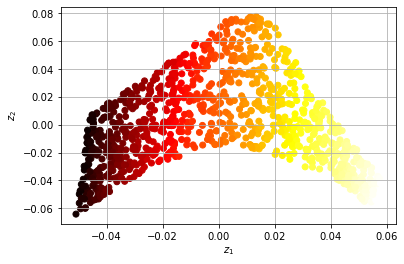

In [39]:
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=t, cmap=plt.cm.hot)
plt.xlabel('$z_1$')
plt.ylabel('$z_2$')
plt.grid(True)

スイスロールが完全にアンロールした。

あるデータ点に対してk個の近傍点を決め、それら近傍点の線形関数として元のデータを再現しようとする。


# Other Dimensionality Reduction Techniques

[Manifold learning](https://scikit-learn.org/stable/modules/manifold.html)

[MDS](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html#sklearn.manifold.MDS): Malti-dimensional Scaling。距離が元の高次元空間の距離をよく尊重するデータの低次元表現を求める。

[Isomap](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap): Isometric Mapping。MDSやKernel PCAの拡張。すべてのポイント間の測地線距離を維持する低次元の埋め込みを求める。


[t-SNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html#sklearn.manifold.TSNE): t-distributed Stochastic Neighbor Embedding。データ点の親和性を確率に変換する。元の空間の親和性はガウス結合確率で表され、埋め込まれた空間の親和性はスチューデントのt分布で表される。

[LDA]():Linear Discriminant Analysis。分類アルゴリズムだが、訓練中に最も特徴的な(discriminative)軸を学習し、それを超平面への投影に用いることができる。クラスを可能な限り離した状態で投影でき、SVMの前処理として良。

In [40]:
from sklearn.manifold import MDS

mds=MDS(n_components=2, random_state=42)
X_reduced_mds=mds.fit_transform(X_swiss)

In [41]:
from sklearn.manifold import Isomap

isomap=Isomap(n_components=2)
X_reduced_isomap=isomap.fit_transform(X_swiss)

In [42]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2, random_state=42)
X_reduced_tsne=tsne.fit_transform(X_swiss)

C:\Users\tkuramot\anaconda3\envs\py310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\tkuramot\anaconda3\envs\py310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [43]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda=LinearDiscriminantAnalysis(n_components=2)
X_mnist=mnist['data']
y_mnist=mnist['target']
lda.fit(X_mnist, y_mnist)
X_reduced_lda=lda.transform(X_mnist)

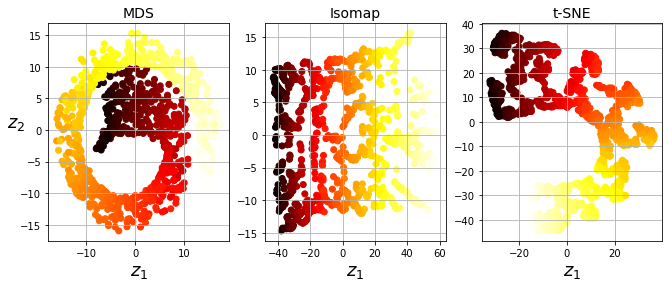

In [44]:
titles=['MDS', 'Isomap', 't-SNE']

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131,132,133), titles,
                                    (X_reduced_mds,X_reduced_isomap,X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:,0],X_reduced[:,1],c=t,cmap=plt.cm.hot)
    plt.xlabel('$z_1$', fontsize=18)
    if subplot ==131:
        plt.ylabel('$z_2$', fontsize=18, rotation=0)
    plt.grid(True)